In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import sys
import torch
from pytorch_lightning.utilities.cli import LightningCLI
import numpy as np

# Add GNN use-case modules to the python path while it is not importable as a lib.
sys.path.append(os.path.dirname(os.getcwd()))
from plotters import Plotter
from inferer import InferencePthGnn
import data # required for CLI be functional. WHy Lightning is so capricious ??

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Inference

In [3]:
# patch the sys.argv to add the GIN config file used from the training of this GNN
sys.argv = [sys.argv[0]]
sys.argv.extend(["--config", "../configs/gin.yaml"])
cli = LightningCLI(run=False)

inferer = InferencePthGnn(
    model_path="/scratch/vincentl/ai4sim/gnn_r2_r3_exp/exp_save/gin_1000epoch_0.96r2/offline-burrito/logs/version_0/checkpoints/epoch=999-step=35999.ckpt",
    data_path='/net/172.16.118.188/data/raise/R2_flame/combustiondatabase/R2-filtered/R3-data/smaller_new_filt_15_F_4_cropped_progvar_R3.h5',
    model_class=cli.model.__class__,
    wkd = "/scratch/vincentl/ai4sim/gnn_r2_r3_exp/"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [4]:
inferer.preprocess(save=True)

In [5]:
output = inferer.predict()

# Post inference analysis

## Data formating and Ground truth retrieval

In [7]:
NORM_VAL = 3295.4

output = torch.reshape(output, (29, 241, 699))

out = output.detach().numpy().T
y_gt_dns = inferer.load_y_dns().T / NORM_VAL
y_gt_les = inferer.load_y_les().T / NORM_VAL

out_n = out[np.newaxis]
y_gt_dns_n = y_gt_dns[np.newaxis]
y_gt_les_n = y_gt_les[np.newaxis]

## Plotting

In [8]:
# If the plot will be saved as image or not
save = False

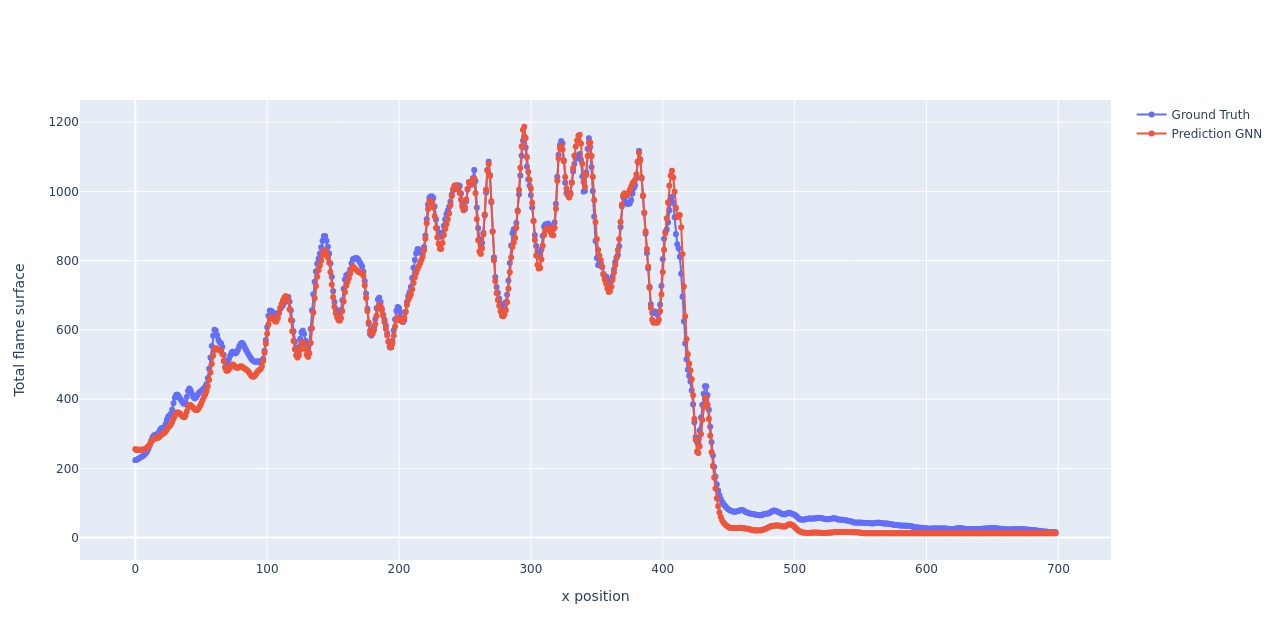

In [9]:
plot = Plotter('R2 to R3', out_n[0].shape)
plot.total_flame_surface(y_gt_dns_n, out_n, save=save)

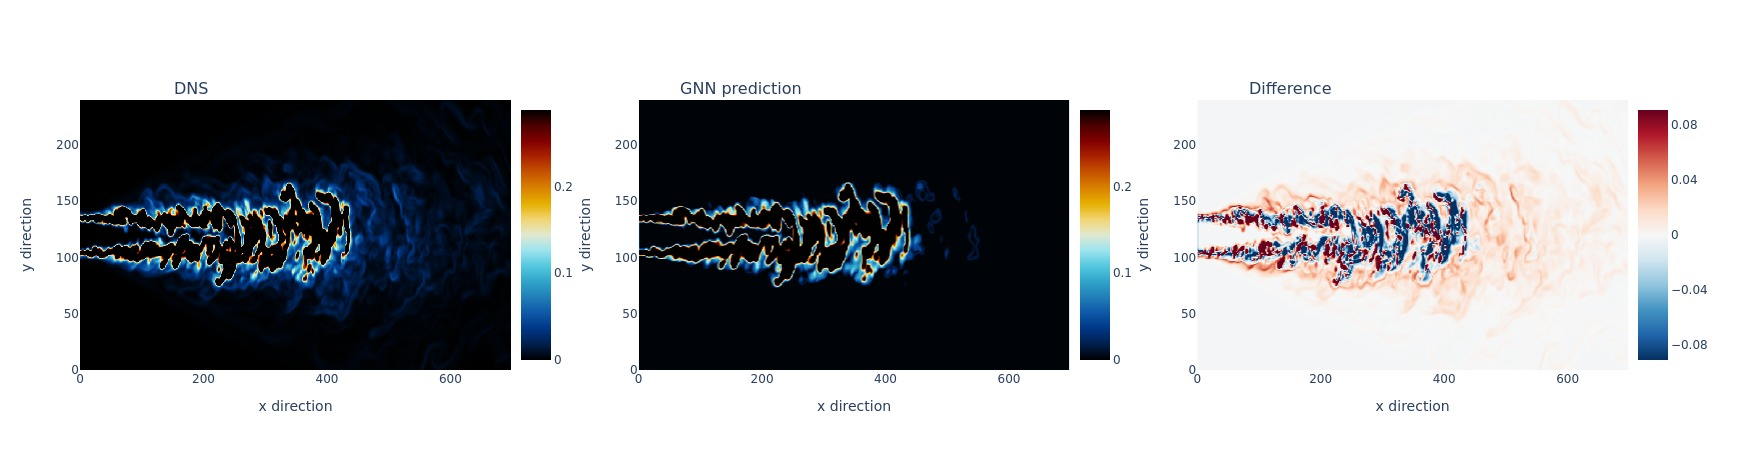

In [10]:
section = 14
plot.cross_section(section, y_gt_dns_n, out_n, "DNS", "GNN prediction", norm_val=NORM_VAL, save=save)

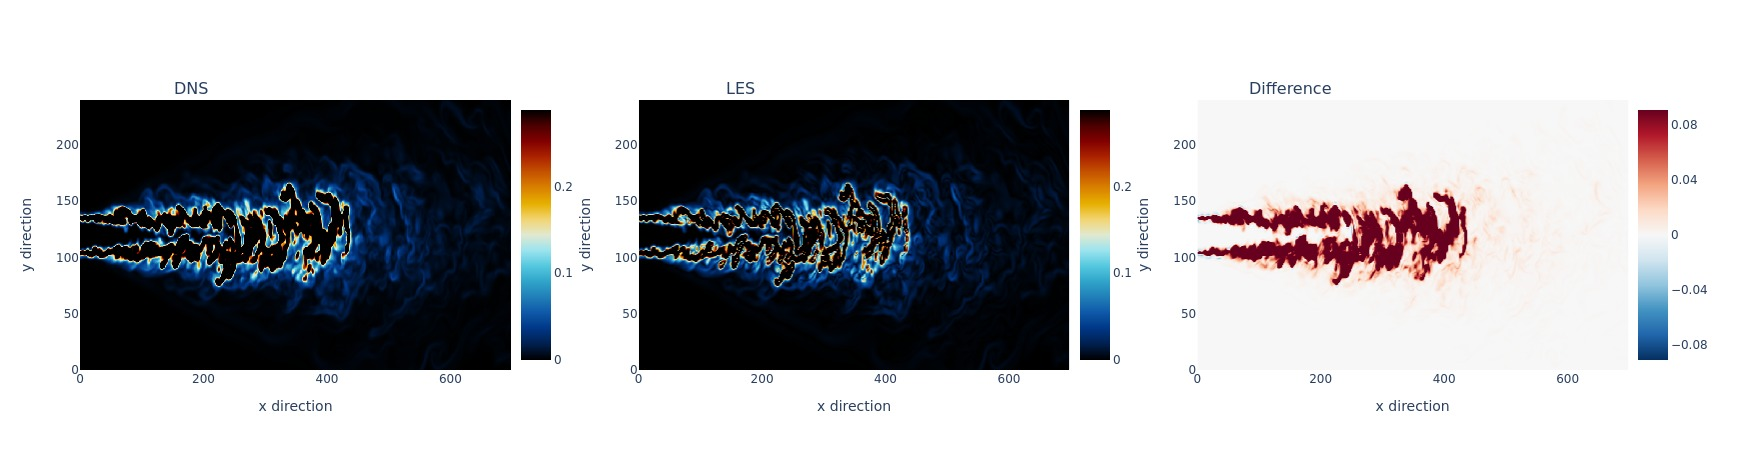

In [11]:
plot = Plotter('DNS vs LES', out_n[0].shape)
plot.cross_section(section, y_gt_dns_n, y_gt_les_n, "DNS", "LES", norm_val=NORM_VAL, save=save)

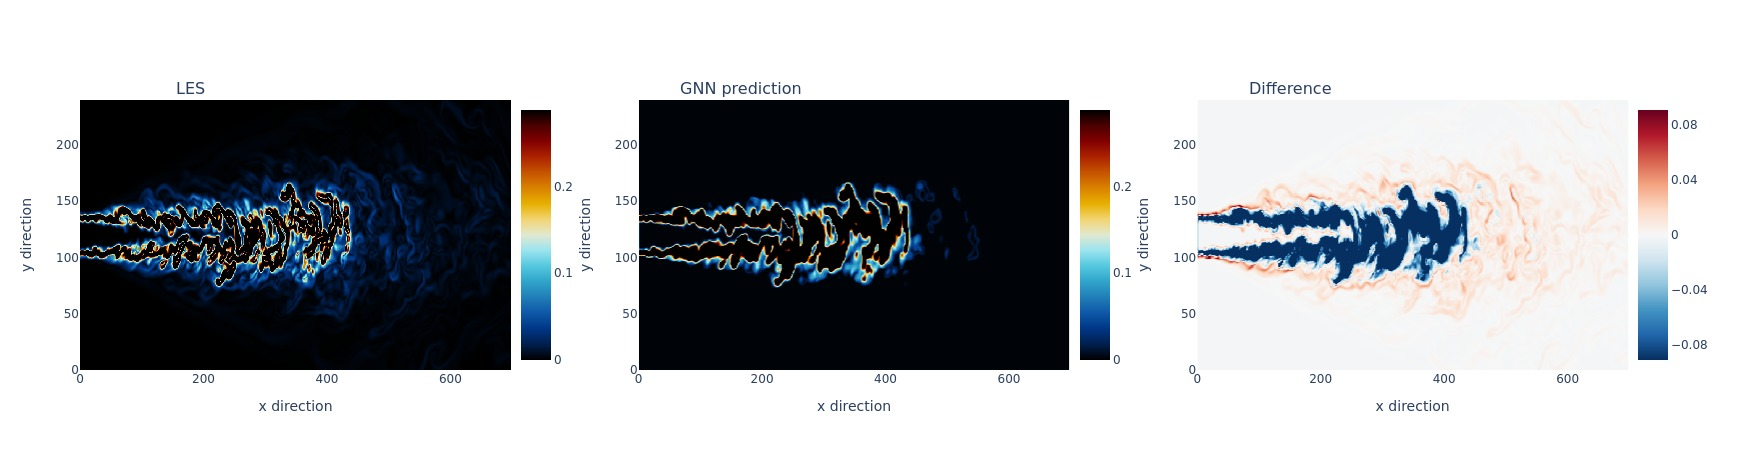

In [12]:
plot = Plotter('GNN vs LES', out_n[0].shape)
plot.cross_section(section, y_gt_les_n, out_n, "LES", "GNN prediction", norm_val=NORM_VAL, save=save)

## Comparison with the CERFAS CNN

In [14]:
#Load the inference result of the CNN (!! cerfacs_cnn.npy file not provided, please refer to the notebook "atos_predict_R3.ipynb" provided by the CERFACS to generate these data !!)
pred = np.load("/scratch/vincentl/ai4sim/gnn_r2_r3_exp/cerfacs_cnn.npy")
pred_n = pred[np.newaxis]

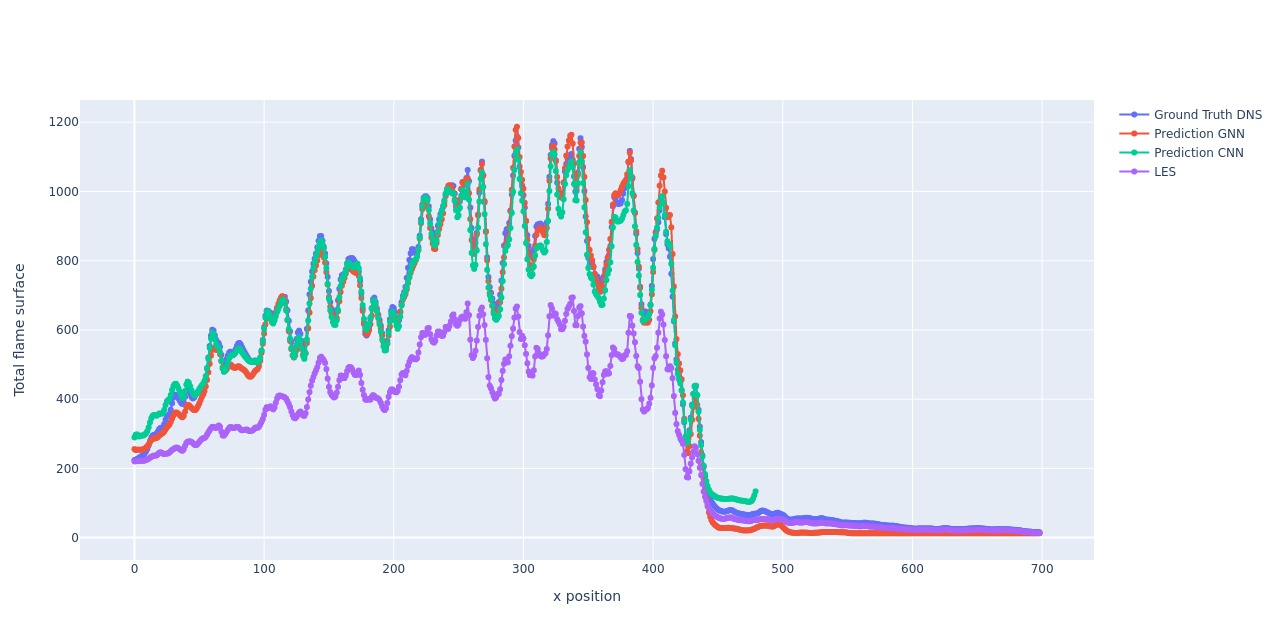

In [15]:
plot_cnn = Plotter('CNN vs GNN', pred_n[0].shape)
plot_cnn.total_flame_surface(y_target=y_gt_dns_n, y_hat=out_n, y_hat_2=pred_n, y_hat_3=y_gt_les_n, target_title="Ground Truth DNS", pred_3_title='LES', save=save)

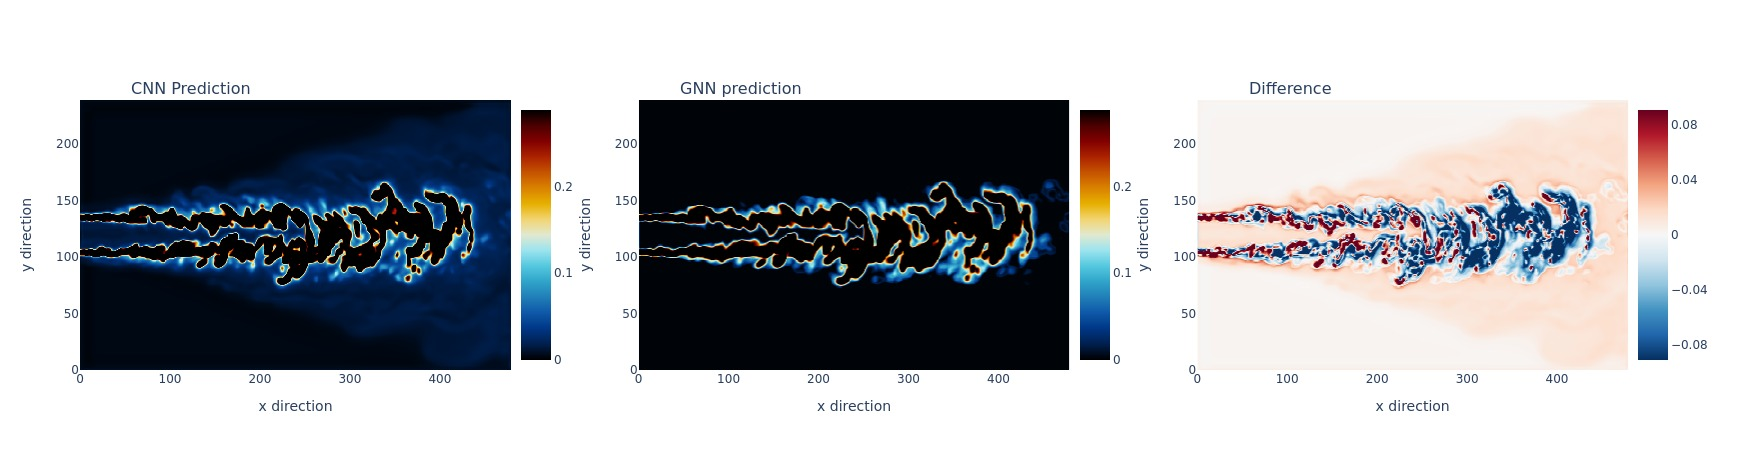

In [16]:
plot_cnn.cross_section(zslice=section, y_val=pred_n, y_hat=out_n[:, :480, :-1, :-1], y_title="CNN Prediction", y_hat_title="GNN prediction", norm_val=NORM_VAL, save=save)

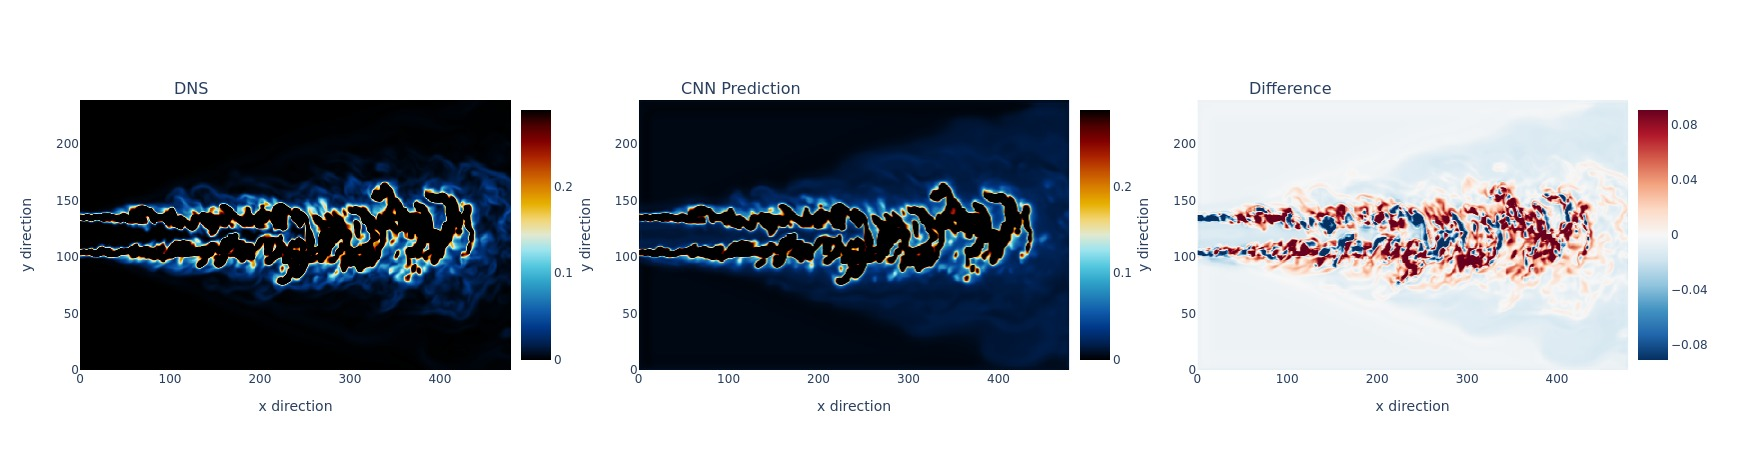

In [17]:
plot_cnn = Plotter('DNS vs CNN', pred_n[0].shape)
plot_cnn.cross_section(zslice=section, y_hat=pred_n, y_val=y_gt_dns_n[:, :480, :-1, :-1], y_hat_title="CNN Prediction", y_title="DNS", norm_val=NORM_VAL, save=save)